In [1]:
ReloadProject('deep_learning')

Path /workspace/external/deep_learning added to PYTHON_PATH.


Using TensorFlow backend.


notebook_init.py imported and reloaded
forwarded symbol: Activation
forwarded symbol: Dense
forwarded symbol: Dict
forwarded symbol: InputLayer
forwarded symbol: List
forwarded symbol: Model
forwarded symbol: Sequential
forwarded symbol: Tuple
reloaded: gym
forwarded symbol: gym
reloaded: keras
forwarded symbol: keras
reloaded: model_optimization
forwarded symbol: model_optimization
reloaded: openai_wrapper
forwarded symbol: openai_wrapper
reloaded: policy_impl
forwarded symbol: policy_impl
reloaded: q_function_memoization
forwarded symbol: q_function_memoization
reloaded: q_learning
forwarded symbol: q_learning
reloaded: q_learning_impl
forwarded symbol: q_learning_impl
reloaded: q_learning_impl_v2
forwarded symbol: q_learning_impl_v2
reloaded: q_learning_impl_v3
forwarded symbol: q_learning_impl_v3
reloaded: q_learning_v2
forwarded symbol: q_learning_v2
reloaded: q_learning_v3
forwarded symbol: q_learning_v3
reloaded: run_callback_function
forwarded symbol: run_callback_function


## Environment Setup
Let's assume a world with 11 states: 0-10. Each time the agent and move +1 or -1, with 0-1 -> 10 and 10+1 -> 0. All actions that gets the agent closer to state "5" gets reward +1, otherwise gets reward -1.

In [2]:
STATE_ZERO_ARRAY = np.zeros(1, dtype=int)
TARGET_STATE = 5
STOP_AFTER_STEPS = 50


class CircularWorld(q_learning_v3.Environment):
    
    def __init__(self, random_initial_location=True):
        super().__init__(state_array_size=1, action_space_size=3)

        self.debug_verbosity = 0
        
        if random_initial_location:
            self._protected_SetState(STATE_ZERO_ARRAY + np.random.randint(0, 10))
        
        # action encoding
        self._action_minus = 0
        self._action_stay = 1
        self._action_plus = 2
        
        # Controls when to stop.
        self._total_steps = 0

        
    #@ Override
    def TakeAction(self, action: q_learning_v2.Action) -> q_learning_v2.Reward:
        current_state = self.GetState()
        new_state = current_state
        reward = 0
        if action == self._action_plus:
            if current_state < TARGET_STATE:
                reward = 1.0
            else:
                reward = -1.0
            new_state = current_state + 1
            if new_state >= 11:
                new_state = STATE_ZERO_ARRAY
        elif action == self._action_minus:
            if current_state > TARGET_STATE:
                reward = 1.0
            else:
                reward = -1.0
            new_state = current_state - 1
            if new_state <= -1:
                new_state = STATE_ZERO_ARRAY + 10
        else:
            if current_state != TARGET_STATE:
                reward = -1.0
            else:
                reward = 1.0

        self._protected_SetState(new_state)
        if self.debug_verbosity >= 1:
            print('Action %s: (%s) -> (%s), reward: %s' % (
                action, current_state, new_state, reward))
            
        self._total_steps += 1
        if self._total_steps > STOP_AFTER_STEPS:
            self._protected_SetDone(True)
        return reward
    
def WorldMaker():
    return CircularWorld()

In [3]:
world = CircularWorld()
i = 0
try:
    for _ in range(600):
        world.TakeAction(0)
        i += 1
except q_learning_v3.EnvironmentDoneSignal:
    pass
print(i)

51


## Performance Benchmark

In [7]:
%%time

env = CircularWorld()
qf1 = q_learning_impl_v3.KerasModelQFunctionIntAction(
    env, (20, 20, 20), learning_rate=0.9, discount_factor=0.95)
qf2 = q_learning_impl_v3.KerasModelQFunctionIntAction(
    env, (20, 20, 20), learning_rate=0.9, discount_factor=0.95)

CPU times: user 160 ms, sys: 0 ns, total: 160 ms
Wall time: 158 ms


In [8]:
%%time

for _ in range(200):
    qf1.UpdateCopy(qf2)

CPU times: user 600 ms, sys: 20 ms, total: 620 ms
Wall time: 588 ms


In [9]:
%%time

for _ in range(200):
    qf2._model.set_weights(qf1._model.get_weights())
    

CPU times: user 280 ms, sys: 30 ms, total: 310 ms
Wall time: 291 ms


In [10]:
%%time

for _ in range(200):
    s = 1
    a = 0
    r = 2.0
    s_new = 2
    qf1.SetValue(
        s, a, qf1.GetNewValueFromTransition(
            s, a, r, s_new, env.GetActionSpace()))

CPU times: user 820 ms, sys: 70 ms, total: 890 ms
Wall time: 800 ms


In [11]:
%%time

for _ in range(200):
    s = 1
    a = 0
    r = 2.0
    s_new = 2
    qf1.GetNewValueFromTransition(
        s, a, r, s_new, env.GetActionSpace())

CPU times: user 290 ms, sys: 50 ms, total: 340 ms
Wall time: 271 ms


In [12]:
%%time

value = np.zeros((1,)) + 0.78
for _ in range(200):
    s = 1
    a = 0
    r = 2.0
    s_new = 2
    qf1.SetValue(s, a, value)

CPU times: user 200 ms, sys: 50 ms, total: 250 ms
Wall time: 200 ms


In [13]:
%%time

sample_space = list(range(50))
for _ in range(200):
    np.random.choice(sample_space)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.34 ms


## Learning

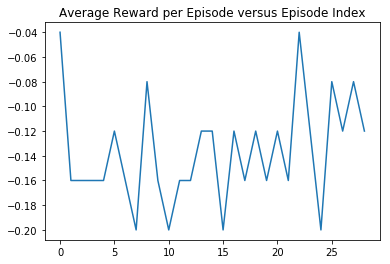

Execution took 702 ms.


KeyboardInterrupt: 

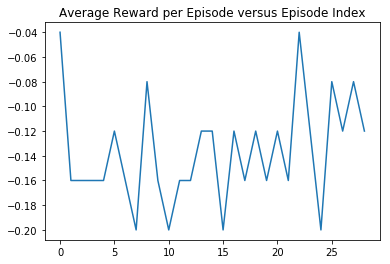

In [110]:
%%time

env = CircularWorld()
qfunc = q_learning_impl_v3.KerasModelQFunctionIntAction(
    env, (6, 6, 6), learning_rate=0.9, discount_factor=0.95)
policy = policy_impl.MaxValueWithRandomnessPolicy(certainty = 0.9)
callback_func = run_callback_function.MonitoringCallback()

q_learning_v3.SimpleRun(
    env_factory=WorldMaker, qfunc=qfunc, policy=policy,
    num_of_episode=1000, callback_func=callback_func,
    debug_verbosity=0)

KeyboardInterrupt: 

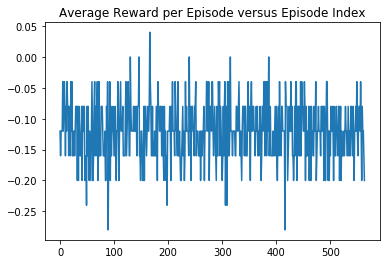

In [3]:
%%time

env = CircularWorld()
qfunc = q_learning_impl_v3.KerasModelQFunctionIntAction(
    env, (6, 6, 6), learning_rate=0.9, discount_factor=0.95)
policy = policy_impl.MaxValueWithRandomnessPolicy(certainty = 0.9)
callback_func = run_callback_function.MonitoringCallback()

q_learning_v3.DQNRun(
    env_factory=WorldMaker, qfunc=qfunc, policy=policy,
    num_of_episode=3000,
    experience_history_capacity=1000, num_training_samples=50, training_every_steps=1,
    callback_func=callback_func,
    debug_verbosity=0)

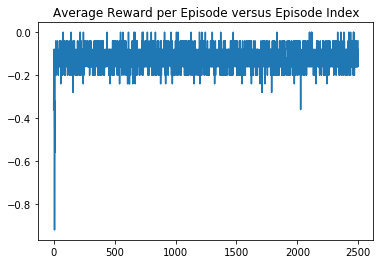

Execution took 7679 ms.


KeyboardInterrupt: 

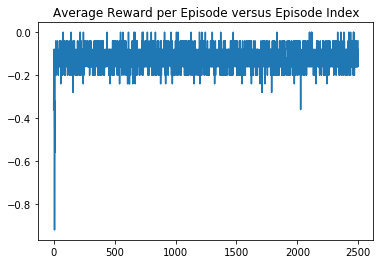

In [14]:
%%time

env = CircularWorld()
qfunc = q_learning_impl_v3.KerasModelQFunctionIntAction(
    env, (20, 20, 20), learning_rate=0.9, discount_factor=0.95)
policy = policy_impl.MaxValueWithRandomnessPolicy(certainty = 0.9)
callback_func = run_callback_function.MonitoringCallback()

q_learning_v3.DQNRun(
    env_factory=WorldMaker, qfunc=qfunc, policy=policy,
    num_of_episode=3000,
    experience_history_capacity=1000, num_training_samples=50, training_every_steps=1,
    callback_func=callback_func,
    debug_verbosity=0)

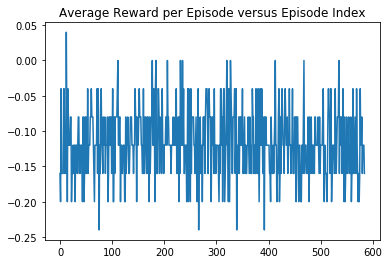

Execution took 3579 ms.


KeyboardInterrupt: 

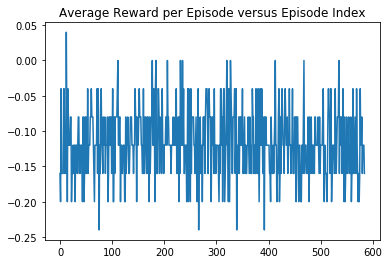

In [15]:
%%time

env = CircularWorld()
qfunc = q_learning_impl_v3.KerasModelQFunctionIntAction(
    env, (6, 20, 12), learning_rate=0.9, discount_factor=0.95)
policy = policy_impl.MaxValueWithRandomnessPolicy(certainty = 0.9)
callback_func = run_callback_function.MonitoringCallback()

q_learning_v3.DQNRun(
    env_factory=WorldMaker, qfunc=qfunc, policy=policy,
    num_of_episode=3000,
    experience_history_capacity=1000, num_training_samples=1000, training_every_steps=100,
    callback_func=callback_func,
    debug_verbosity=0)

KeyboardInterrupt: 

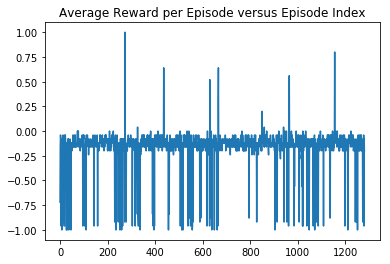

In [16]:
%%time

env = CircularWorld()
qfunc = q_learning_impl_v3.MultiModelQFunction(
    env, (6, 20), (12, 4), learning_rate=0.9, discount_factor=0.95)
policy = policy_impl.MaxValueWithRandomnessPolicy(certainty = 0.9)
callback_func = run_callback_function.MonitoringCallback()

q_learning_v3.DQNRun(
    env_factory=WorldMaker, qfunc=qfunc, policy=policy,
    num_of_episode=3000,
    experience_history_capacity=1000, num_training_samples=1000, training_every_steps=100,
    callback_func=callback_func,
    debug_verbosity=0)